# [Deep Learning for Vision Systems](https://www.manning.com/books/deep-learning-for-vision-systems?a_aid=compvisionbookcom&a_bid=90abff15) Book


## Resnet50 implementation with Keras

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform

Using TensorFlow backend.


### Identity block

![title](images/idblock.png)

### Reduce block
![title](images/reduceblock.png)

In [2]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X



ResNet50 implementation with the following architecture:

![title](images/resnet_architectures.png)

In [3]:
def ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [4]:
model = ResNet50(input_shape = (32,32, 3), classes = 10)

In [5]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 13, 13, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 13, 13, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 13, 13, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Visualize the network using plot_model

*Installation*
- conda install graphviz
- conda install pydotplus

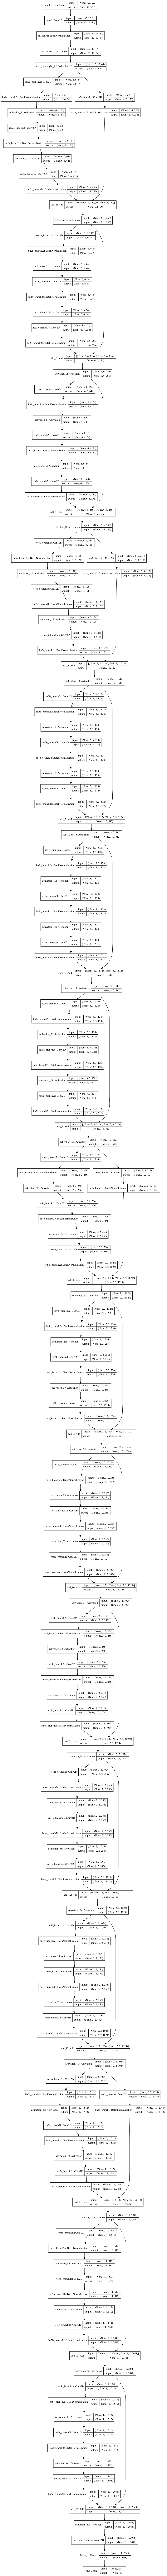

In [6]:
from keras.utils import plot_model

plot_model(model, to_file="images/resnet50.png", show_shapes=True)